<a href="https://colab.research.google.com/github/lebrice/IFT6135/blob/master/A1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT 6135, Assignment 1, Practical Problem 3
*Team members*: Jérôme Parent-Lévesque (20143161), Arnold Kokoroko, Fabrice Normandin

## Table of Contents:
### Sections
1. [Imports](#imports)
2. [Load the data](#load)
3. [Check that the data was loaded correctly](#check)
4. [Training utilities](#training)
5. [Define the model](#define)
6. [Model Training](#model_training)
7. [Evaluating on the test set](#evaluating)
8. [Analysis](#analysis)

### Answers to assignment questions:
1. [Architecture](#architecture)
2. [Error Curves](#error)
3. [Hyperparameters](#hyperparams)

## Imports <a name="imports"></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()
import PIL

import os
import time
import copy

from zipfile import ZipFile
from google.colab import drive
from google.colab import files

## Load the data <a name="load"></a>

In [0]:
# # Use this cell to upload the training and testing datasets manually, or the one below to use a Google Drive mount.

# root_path = ""

# import os

# def upload_if_not_present(file_name: str):
#     file_path = os.path.join(root_path, file_name) 
#     if not os.path.isfile(file_path):
#         print(f"Please upload the  '{file_name}' file.")
#         return files.upload()
#     else:
#         print(f"File found at '{file_path}', skipping the upload.")
#         return file_path, open(file_path, 'r')
    
# train_dataset_file = upload_if_not_present("trainset.zip")
# test_dataset_file = upload_if_not_present("testset.zip")

In [15]:
# Load the dataset from google drive. The zip files must be located at the 'root_path'
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/IFT6135/A1/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load and unzip the trainset and testset



zip_ref = ZipFile(root_path + 'trainset.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

zip_ref = ZipFile(root_path + 'testset.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [0]:
# Rename the test files so that they are read in the correct order by the PyTorch ImageFolder loader
for root, _, fnames in sorted(os.walk('./testset/test')):
    for fname in sorted(fnames):
        old_path = os.path.join(root, fname)
        split = fname.split('.')
        f_id = split[0]
        new_name = f_id.zfill(4) + '.' + split[1] # Pad with 0s
        new_path = os.path.join(root, new_name)
        os.rename(old_path, new_path)

In [0]:
# Define the Label constants
label_names = {
    0: 'Cat',
    1: 'Dog'
}

In [0]:
# Load the data into pytorch loaders, along with some transforms for data augmentation
train_transforms = transforms.Compose([
        transforms.Resize(64 + 16, interpolation=PIL.Image.BICUBIC),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # TODO
])

test_transforms = transforms.Compose([
    transforms.Resize(64 + 16, interpolation=PIL.Image.BICUBIC),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.ImageFolder('./trainset', transform=train_transforms)
valid_data = torchvision.datasets.ImageFolder('./trainset', transform=test_transforms)
test_data = torchvision.datasets.ImageFolder('./testset', transform=test_transforms)

# Split the data into a training and validation set
VALID_SIZE = 0.1 # 10% of the data
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * len(train_data)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)


def load_data(batch_size=10):
    trainloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=torch.cuda.is_available())
    train_size = len(train_data) - split

    validloader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2, pin_memory=torch.cuda.is_available())
    valid_size = split

    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
    test_size = len(test_data)

    dataloaders = { 'train': trainloader, 'valid': validloader, 'test': testloader }
    dataset_sizes = { 'train': train_size, 'valid': valid_size, 'test': test_size }
    return dataloaders, dataset_sizes

dataloaders, dataset_sizes = load_data()
trainloader = dataloaders["train"]
testloader = dataloaders["test"]


## Check that the data was loaded correctly <a name="check"></a>

In [0]:
# Utility method to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0])


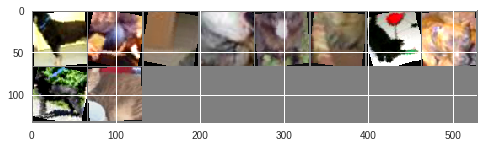

In [21]:
# Test that the data was loaded correctly by visualizing some of the transformed training images
images, labels = iter(trainloader).next()
print(labels)
imshow(torchvision.utils.make_grid(images))

## Training utilities <a name="training"></a>

In [0]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, num_epochs=25, scheduler=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    accuracies = { 'train': [], 'valid': [] }
    losses = { 'train': [], 'valid': [] }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model if it performed better
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Plot the training vs validation accuracy graph
    fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 9))
    ax1.plot(accuracies['train'], 'bo-', label='Training Accuracy')
    ax1.plot(accuracies['valid'], 'go-', label='Validation Accuracy')
    ax1.set_title('Training vs Validation accuracy over training time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(losses['train'], 'bo-', label='Training Loss')
    ax2.plot(losses['valid'], 'go-', label='Validation Loss')
    ax2.set_title('Training vs Validation loss over training time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

## 1. Architecture <a name="architecture"></a>
The network architecture was very strongly inspired by VGG. Indeed, the network consists of a series of convolutional layers with ReLU non-linearities with small 3x3 kernels followed by max pooling layers of size 2 that reduce the size of the feature maps by half. The full architecture is:
- Convolutional Layer (64 7x7 kernels, with 3 padding) with ReLU non-linearity
- Convolutional Layer (64 3x3 kernels, with 1 padding) with ReLU non-linearity
- Max Pooling Layer (non-overlapping windows of size 2x2)
- Convolutional Layer (128 3x3 kernels, with 3 padding) with ReLU non-linearity
- Convolutional Layer (128 3x3 kernels, with 3 padding) with ReLU non-linearity
- Max Pooling Layer (non-overlapping windows of size 2x2)
- Convolutional Layer (256 3x3 kernels, with 3 padding) with ReLU non-linearity
- Convolutional Layer (256 3x3 kernels, with 3 padding) with ReLU non-linearity
- Convolutional Layer (256 3x3 kernels, with 3 padding) with ReLU non-linearity
- Max Pooling Layer (non-overlapping windows of size 2x2)
- Dense Linear Layer that maps all feature map neurons to a hidden layer of size 1024, with ReLU non-linearity
- Dense Linear Layer with 1024 hidden neurons, with ReLU non-linearity
- Output Linear Layer with 2 output neurons, without any activation function

The total number of parameters for this architecture is thus $$3\cdot7\cdot7\cdot64 + 64\cdot3\cdot3\cdot64 + 64\cdot3\cdot3\cdot128 + ... = 19 569 856$$

The weights are initilized using He's initialization for Convolutional layers and Normal initialization for Linear layers.

The biggest difference with VGG is that Dropout is not used in this architecture.

Note that although the output layer has two neurons and that the whole network is trained using a cross-entropy loss function, it might have been better to have a single output neuron and to train this network using a mean-squared error loss function. We did not test this.

In [0]:
# Model inspired by VGG
# No Dropout layers used here
class SweetModel(nn.Module):
    def __init__(self):
        super(SweetModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 64 kernels, 3 input channels
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2)
        )
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 2. Model Training <a name="model_training"></a>

In order to increase our validation performance, we performed different kinds of data augmentation on our training dataset, including random resizing, flipping, rotation, and color manipulation:
```
train_transforms = transforms.Compose([
        transforms.Resize(64 + 16, interpolation=PIL.Image.BICUBIC),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # TODO
])
```
- _Plot the training error and validation error curves, along with the training and validation losses. Comment on them._

Here below is a log of the training and validation errors and accuracy over the course of the model training, followed by two curves showing the results graphically.

![(This image should show the error curves)](https://drive.google.com/open?id=1o8tl_iCiNlP6sgNfkEgM0C_aX4D0ssg2)



What can seem a bit strange at first is the fact that the validation loss seems to be consistently lower than the training loss, with a higher validation accuracy than training accuracy. This can however be explained by the fact that all the data augmentation techniques applied to our training dataset are absent from the validation dataset, hence the training loss is driven up by all these perturbations. This in fact serves to prove that our data augmentations improve the model's accuracy.  

- _What techniques (you did not implement) could be useful to improve the validation performance?_ 

Some of the techniques that could be useful to improve the validation performance include Dropout and Batch Normalization, which we did not implement. The Dropout layer was originally used within the VGG network, but we did not include it as part of our achitecture.

- _How does your validation performance compare to the test set performance (that you can only get in Kaggle).?_

Our validation accuracy after 40 epochs of training is approximately __0.8799__, whereas our Kaggle Test accuracy was __0.89040__.
	

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
LEARNING_RATE = 0.05
# MOMENTUM = 0.9 Not allowed
EPOCHS = 40

Training on cuda:0


In [0]:
# # Skip training:
# model = SweetModel()
# model.load_state_dict(torch.load("model_save.pt")) # Restore from save file

Epoch 0/39
----------
train Loss: 0.6888 Acc: 0.5357
valid Loss: 0.6662 Acc: 0.6318

Epoch 1/39
----------
train Loss: 0.6706 Acc: 0.5895
valid Loss: 0.6368 Acc: 0.6593

Epoch 2/39
----------
train Loss: 0.6499 Acc: 0.6250
valid Loss: 0.5957 Acc: 0.7004

Epoch 3/39
----------
train Loss: 0.6365 Acc: 0.6370
valid Loss: 0.5805 Acc: 0.6998

Epoch 4/39
----------
train Loss: 0.6153 Acc: 0.6642
valid Loss: 0.5482 Acc: 0.7399

Epoch 5/39
----------
train Loss: 0.6048 Acc: 0.6732
valid Loss: 0.5220 Acc: 0.7529

Epoch 6/39
----------
train Loss: 0.5909 Acc: 0.6867
valid Loss: 0.5335 Acc: 0.7214

Epoch 7/39
----------
train Loss: 0.5446 Acc: 0.7231
valid Loss: 0.4539 Acc: 0.7949

Epoch 8/39
----------
train Loss: 0.5389 Acc: 0.7268
valid Loss: 0.4578 Acc: 0.7819

Epoch 9/39
----------
train Loss: 0.5257 Acc: 0.7343
valid Loss: 0.4535 Acc: 0.7869

Epoch 10/39
----------
train Loss: 0.5157 Acc: 0.7342
valid Loss: 0.4098 Acc: 0.7969

Epoch 11/39
----------
train Loss: 0.5078 Acc: 0.7446
valid Loss

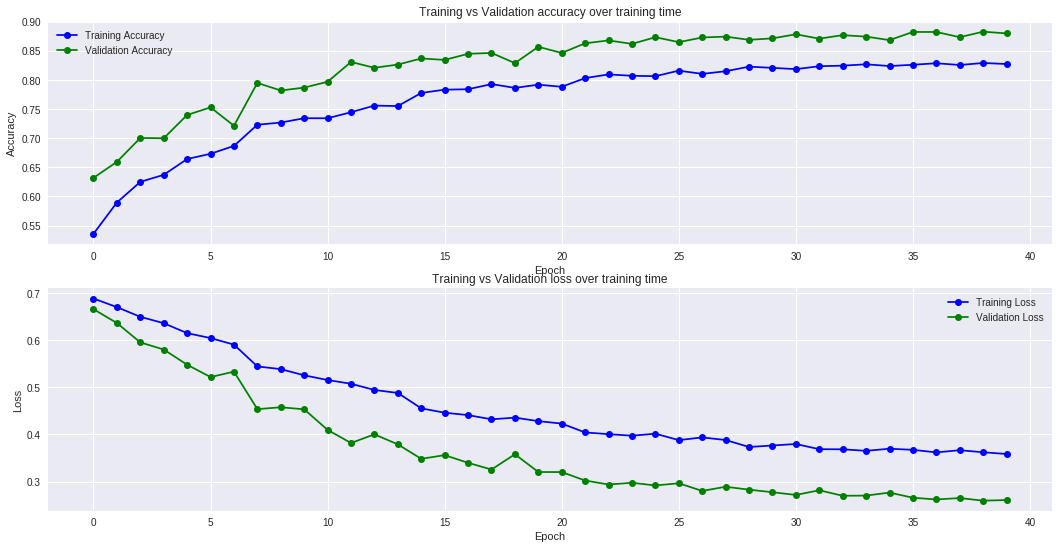

In [0]:
# Set up and start training
model = SweetModel()
# model = models.resnet18(num_classes=2)
# model.load_state_dict(torch.load(os.path.join(root_path, "model_save.pt"))) # Restore from save file
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

model, best_acc = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, num_epochs=EPOCHS, scheduler=exp_lr_scheduler)

In [0]:
# Save the model and automatically download it
save_file = "model_save.pt"
torch.save(model.state_dict(), save_file)
files.download(save_file)

## Evaluating on the test set <a name="evaluating"></a>

In [0]:
# Evaluate on the test set and output a csv file of the final predictions to upload to Kaggle
output_file = 'test_predictions.csv'

model.eval()
prediction_strings = []

for inputs, _ in testloader:
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs.data, 1)
    
    prediction_strings += [label_names[pred] for pred in predictions.cpu().numpy()]

csv_output = pd.DataFrame({ 'label': prediction_strings })
csv_output.index = np.arange(1, len(csv_output) + 1) # Make sure the index starts at 1, not 0
csv_output.to_csv(output_file, index_label='id')
files.download(output_file)

## 3. Hyper-Parameter Search <a name="hyperparams"></a>


- _Compare different hyperparameter settings and report the final results of performance on your validation set._

Given our limited timeframe, and the fact that each run takes approximately an hour to execute, we decided to narrow the scope of our hyperparameter tuning significantly. As such, we chose to evaluate only a few parameters:

Learning Rate: 0.1, 0.05, 0.01

Batch Size: 10, 32

The scope of such a search is admitedly very narrow, with only six combinations to test. Nevertheless, given our time and resource constraints, these two parameters seemed like the most promising ones to test out. Here are our results (which can also be seen below in full detail):


- Learning Rate: 0.1; Batch Size: 10:  Validation Accuracy: __0.8989__
- Learning Rate: 0.1; Batch Size: 32:  Validation Accuracy: __0.8659__
- Learning Rate: 0.05; Batch Size: 10:  Validation Accuracy: __0.8504__ (partial run)
- Learning Rate: 0.05; Batch Size: 32:  Validation Accuracy: __0.8389__
- Learning Rate: 0.01; Batch Size: 10:  Validation Accuracy: __0.8154__
- Learning Rate: 0.01; Batch Size: 32:  Validation Accuracy: __0.7454__



_Aside from quantitative results, also include some visual analysis such as visualizing the feature maps or kernels, or showing examples where the images are (a) clearly misclassified and (b) where the classiffer predicts around 50% on both classes._

### Visualization of the feature kernels of the first layer

torch.Size([64, 3, 7, 7])


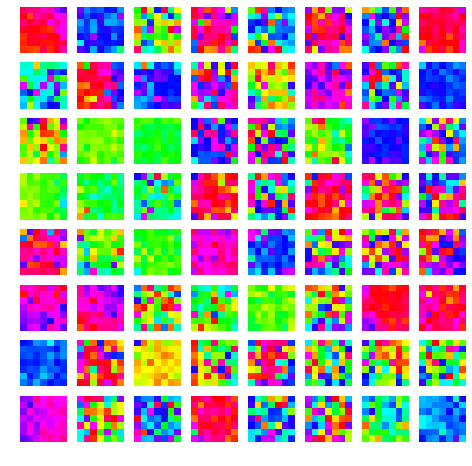

In [0]:
# Show the kernels in the first convolution layer
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        fig = plt.figure(figsize=(8, 8))
        i = 1
        for t in module.weight.data.detach().cpu():
            # Normalize the tensor (per channel):
            t -= t.min(0)[0]
            t /= t.max(0)[0] - t.min(0)[0]
            
            # Show the image
            ax = fig.add_subplot(8, 8, i)
            ax.imshow(transforms.ToPILImage()(t), interpolation='none')
            ax.axis('off')
            i += 1
        print(module.weight.shape)
#         plt.imshow(module.weight.detach().cpu().numpy()[0])
        plt.show()
        break # Only show the first layer

### Misclassified and Indecisive Image examples:


In [0]:

for inputs, labels in testloader:
    inputs = inputs.to(device)
    found = False
    outputs = model(inputs)
    _, predictions = torch.max(outputs.data, 1)
    predictions = predictions.cpu().numpy()
    for i, (real, pred) in enumerate(zip(labels, predictions)):
        if real != pred:
            print(f"MISCLASSIFIED at example {i}")
            print("Real label: ", real, "Prediction: ", pred)
            plt.imshow(transforms.ToPILImage()(inputs[i].cpu()))
            found=True
            break
    if found:
        break
            

#### Setup code:

In [0]:
from typing import Tuple, Dict, List, Iterable

def train_function(learning_rate: float, batch_size: int, epochs:int=EPOCHS) -> Tuple[SweetModel, float]:
    print("learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs)
    
    # Set up and start training
    m = SweetModel()
    m.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(m.parameters(), lr=learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

    dataloaders, dataset_sizes = load_data(batch_size)
    
#     return None, np.random.random()
    return train_model(m, dataloaders, dataset_sizes, criterion, optimizer, device, num_epochs=epochs, scheduler=exp_lr_scheduler)
       
     
def all_combinations_iterator(params: Dict[str, List]) -> Iterable:
    """taken from:
    https://stackoverflow.com/questions/44887695/execute-function-on-all-possible-combinations-of-parameters
    """
    import itertools
    keys = list(params)
    for values in itertools.product(*map(params.get, keys)):
        yield dict(zip(keys, values))    

### Hyperparameter Runs




In [0]:
hyperparameters={
    "learning_rate": [0.1, 0.05, 0.01],
    "batch_size": [10, 32],
}

hyperparameter_combinations = list(all_combinations_iterator(hyperparameters))

num_runs = len(hyperparameter_combinations)

models = [None] * num_runs
accuracies = [None] * num_runs

def run(run_number: int, epochs = 30):
    if run_number >= num_runs:
        print("Already done.")
        return
    
    model, accuracy = train_function(epochs=epochs, **hyperparameter_combinations[run_number])
    models[run_number] = model
    accuracies[run_number] = accuracies
    

learning_rate: 0.1 batch_size: 10 epochs: 30
Epoch 0/29
----------
train Loss: 0.6861 Acc: 0.5495
valid Loss: 0.6623 Acc: 0.6118

Epoch 1/29
----------
train Loss: 0.6704 Acc: 0.5971
valid Loss: 0.6763 Acc: 0.5683

Epoch 2/29
----------
train Loss: 0.6567 Acc: 0.6145
valid Loss: 0.5843 Acc: 0.6938

Epoch 3/29
----------
train Loss: 0.6389 Acc: 0.6370
valid Loss: 0.5516 Acc: 0.7269

Epoch 4/29
----------
train Loss: 0.6280 Acc: 0.6506
valid Loss: 0.5580 Acc: 0.7264

Epoch 5/29
----------
train Loss: 0.6120 Acc: 0.6686
valid Loss: 0.6079 Acc: 0.6578

Epoch 6/29
----------
train Loss: 0.5998 Acc: 0.6789
valid Loss: 0.4769 Acc: 0.7724

Epoch 7/29
----------
train Loss: 0.5509 Acc: 0.7143
valid Loss: 0.4675 Acc: 0.7709

Epoch 8/29
----------
train Loss: 0.5424 Acc: 0.7208
valid Loss: 0.4275 Acc: 0.8034

Epoch 9/29
----------
train Loss: 0.5254 Acc: 0.7300
valid Loss: 0.4683 Acc: 0.7704

Epoch 10/29
----------
train Loss: 0.5131 Acc: 0.7398
valid Loss: 0.3986 Acc: 0.8164

Epoch 11/29
-------

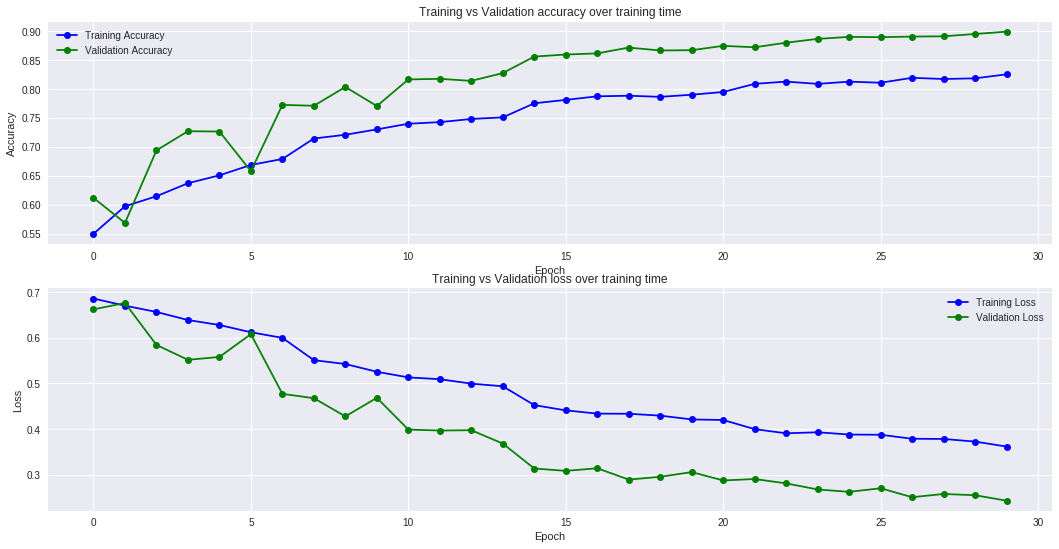

This new combination yielded the current best model so far.


In [0]:
run(0)

learning_rate: 0.1 batch_size: 32 epochs: 30
Epoch 0/29
----------
train Loss: 0.6891 Acc: 0.5359
valid Loss: 0.6758 Acc: 0.5728

Epoch 1/29
----------
train Loss: 0.6744 Acc: 0.5804
valid Loss: 0.6665 Acc: 0.5738

Epoch 2/29
----------
train Loss: 0.6544 Acc: 0.6103
valid Loss: 0.6056 Acc: 0.6638

Epoch 3/29
----------
train Loss: 0.6369 Acc: 0.6390
valid Loss: 0.6492 Acc: 0.6103

Epoch 4/29
----------
train Loss: 0.6251 Acc: 0.6523
valid Loss: 0.5907 Acc: 0.6873

Epoch 5/29
----------
train Loss: 0.6155 Acc: 0.6639
valid Loss: 0.5406 Acc: 0.7209

Epoch 6/29
----------
train Loss: 0.6041 Acc: 0.6725
valid Loss: 0.5776 Acc: 0.7004

Epoch 7/29
----------
train Loss: 0.5685 Acc: 0.7034
valid Loss: 0.4692 Acc: 0.7724

Epoch 8/29
----------
train Loss: 0.5559 Acc: 0.7142
valid Loss: 0.4627 Acc: 0.7809

Epoch 9/29
----------
train Loss: 0.5449 Acc: 0.7182
valid Loss: 0.4798 Acc: 0.7599

Epoch 10/29
----------
train Loss: 0.5394 Acc: 0.7274
valid Loss: 0.4944 Acc: 0.7554

Epoch 11/29
-------

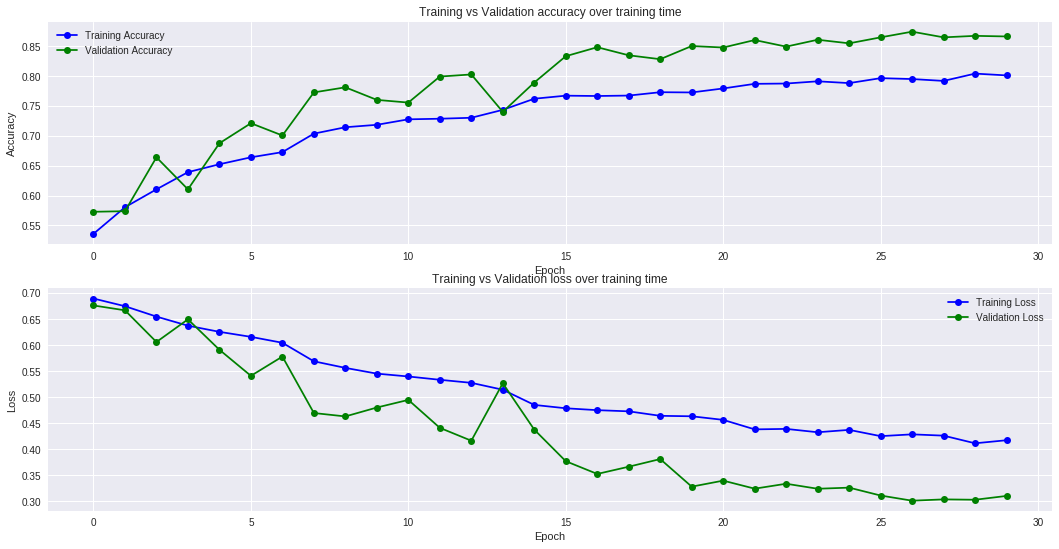

In [0]:
run(1)

In [0]:
run(2)

learning_rate: 0.05 batch_size: 10 epochs: 30
Epoch 0/29
----------
train Loss: 0.6886 Acc: 0.5415
valid Loss: 0.6676 Acc: 0.6328

Epoch 1/29
----------
train Loss: 0.6684 Acc: 0.5947
valid Loss: 0.6413 Acc: 0.6063

Epoch 2/29
----------
train Loss: 0.6503 Acc: 0.6225
valid Loss: 0.6109 Acc: 0.6793

Epoch 3/29
----------
train Loss: 0.6331 Acc: 0.6460
valid Loss: 0.6578 Acc: 0.6233

Epoch 4/29
----------
train Loss: 0.6200 Acc: 0.6555
valid Loss: 0.5679 Acc: 0.6998

Epoch 5/29
----------
train Loss: 0.6057 Acc: 0.6746
valid Loss: 0.5018 Acc: 0.7609

Epoch 6/29
----------
train Loss: 0.5867 Acc: 0.6896
valid Loss: 0.4812 Acc: 0.7774

Epoch 7/29
----------
train Loss: 0.5524 Acc: 0.7111
valid Loss: 0.4887 Acc: 0.7644

Epoch 8/29
----------
train Loss: 0.5396 Acc: 0.7220
valid Loss: 0.4449 Acc: 0.7919

Epoch 9/29
----------
train Loss: 0.5315 Acc: 0.7248
valid Loss: 0.4391 Acc: 0.7899

Epoch 10/29
----------
train Loss: 0.5178 Acc: 0.7367
valid Loss: 0.4453 Acc: 0.7899

Epoch 11/29
------

learning_rate: 0.05 batch_size: 32 epochs: 30
Epoch 0/29
----------
train Loss: 0.6915 Acc: 0.5217
valid Loss: 0.6917 Acc: 0.5093

Epoch 1/29
----------
train Loss: 0.6814 Acc: 0.5701
valid Loss: 0.7123 Acc: 0.5263

Epoch 2/29
----------
train Loss: 0.6667 Acc: 0.6017
valid Loss: 0.6537 Acc: 0.6108

Epoch 3/29
----------
train Loss: 0.6499 Acc: 0.6182
valid Loss: 0.6081 Acc: 0.7094

Epoch 4/29
----------
train Loss: 0.6344 Acc: 0.6389
valid Loss: 0.6178 Acc: 0.6508

Epoch 5/29
----------
train Loss: 0.6275 Acc: 0.6491
valid Loss: 0.5736 Acc: 0.6988

Epoch 6/29
----------
train Loss: 0.6146 Acc: 0.6579
valid Loss: 0.5606 Acc: 0.7169

Epoch 7/29
----------
train Loss: 0.5878 Acc: 0.6853
valid Loss: 0.5174 Acc: 0.7589

Epoch 8/29
----------
train Loss: 0.5811 Acc: 0.6909
valid Loss: 0.5058 Acc: 0.7604

Epoch 9/29
----------
train Loss: 0.5694 Acc: 0.7014
valid Loss: 0.4869 Acc: 0.7754

Epoch 10/29
----------
train Loss: 0.5644 Acc: 0.7066
valid Loss: 0.4850 Acc: 0.7699

Epoch 11/29
------

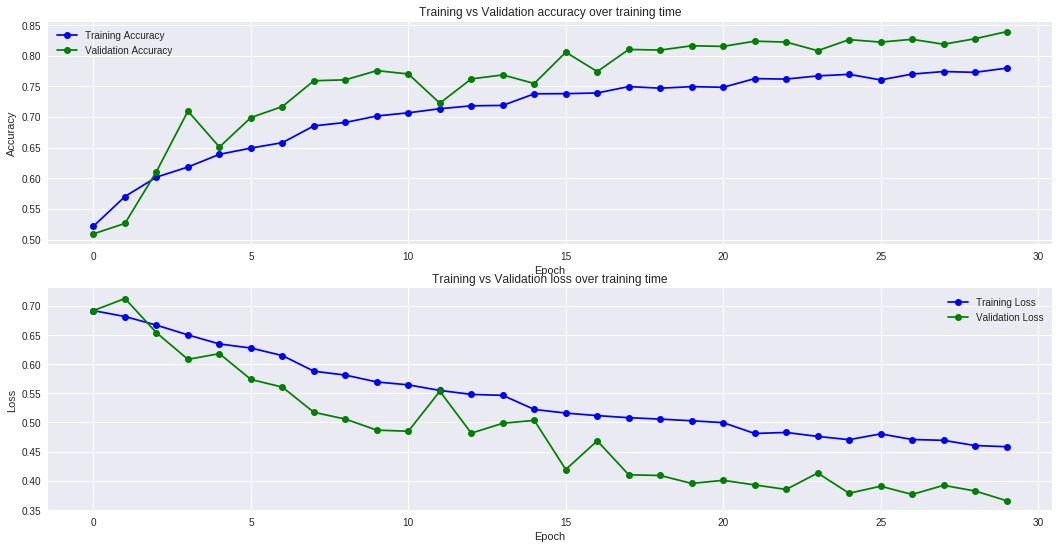

In [0]:
run(3)

learning_rate: 0.01 batch_size: 10 epochs: 30
Epoch 0/29
----------
train Loss: 0.6924 Acc: 0.5146
valid Loss: 0.6881 Acc: 0.5823

Epoch 1/29
----------
train Loss: 0.6832 Acc: 0.5604
valid Loss: 0.6729 Acc: 0.5798

Epoch 2/29
----------
train Loss: 0.6742 Acc: 0.5823
valid Loss: 0.6498 Acc: 0.6528

Epoch 3/29
----------
train Loss: 0.6642 Acc: 0.6005
valid Loss: 0.6287 Acc: 0.6668

Epoch 4/29
----------
train Loss: 0.6512 Acc: 0.6163
valid Loss: 0.5983 Acc: 0.6808

Epoch 5/29
----------
train Loss: 0.6345 Acc: 0.6392
valid Loss: 0.5900 Acc: 0.6728

Epoch 6/29
----------
train Loss: 0.6227 Acc: 0.6543
valid Loss: 0.5590 Acc: 0.7204

Epoch 7/29
----------
train Loss: 0.6017 Acc: 0.6733
valid Loss: 0.5301 Acc: 0.7414

Epoch 8/29
----------
train Loss: 0.5923 Acc: 0.6812
valid Loss: 0.5191 Acc: 0.7514

Epoch 9/29
----------
train Loss: 0.5837 Acc: 0.6909
valid Loss: 0.5090 Acc: 0.7579

Epoch 10/29
----------
train Loss: 0.5820 Acc: 0.6910
valid Loss: 0.5212 Acc: 0.7494

Epoch 11/29
------

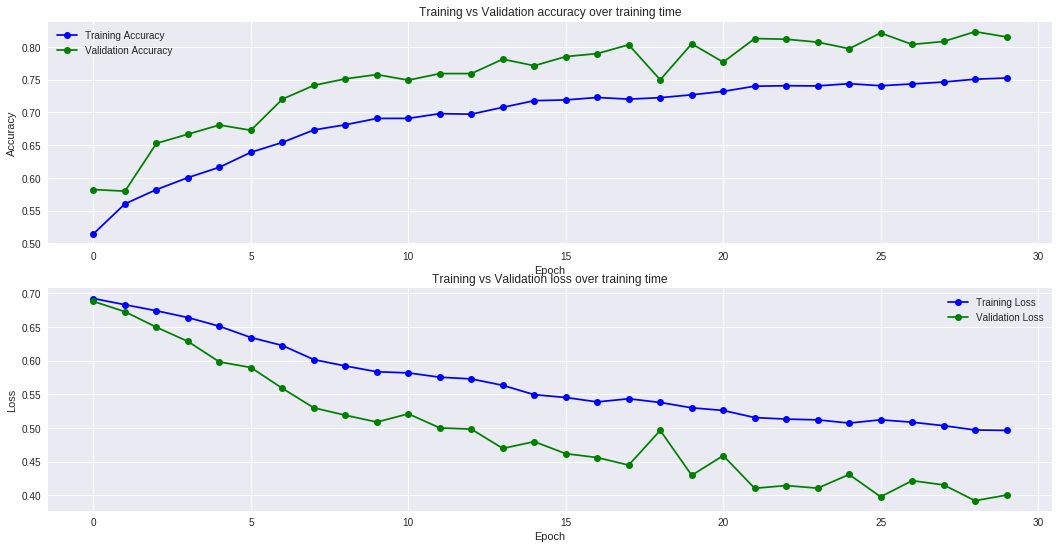

In [0]:
run(4)

learning_rate: 0.01 batch_size: 32 epochs: 30
Epoch 0/29
----------
train Loss: 0.6929 Acc: 0.5111
valid Loss: 0.6923 Acc: 0.5028

Epoch 1/29
----------
train Loss: 0.6914 Acc: 0.5318
valid Loss: 0.6898 Acc: 0.5063

Epoch 2/29
----------
train Loss: 0.6833 Acc: 0.5585
valid Loss: 0.6697 Acc: 0.6033

Epoch 3/29
----------
train Loss: 0.6776 Acc: 0.5736
valid Loss: 0.6622 Acc: 0.6133

Epoch 4/29
----------
train Loss: 0.6728 Acc: 0.5793
valid Loss: 0.6531 Acc: 0.6288

Epoch 5/29
----------
train Loss: 0.6651 Acc: 0.5974
valid Loss: 0.6822 Acc: 0.5588

Epoch 6/29
----------
train Loss: 0.6594 Acc: 0.6076
valid Loss: 0.6247 Acc: 0.6583

Epoch 7/29
----------
train Loss: 0.6485 Acc: 0.6235
valid Loss: 0.6210 Acc: 0.6388

Epoch 8/29
----------
train Loss: 0.6401 Acc: 0.6330
valid Loss: 0.6019 Acc: 0.6773

Epoch 9/29
----------
train Loss: 0.6382 Acc: 0.6338
valid Loss: 0.6121 Acc: 0.6808

Epoch 10/29
----------
train Loss: 0.6354 Acc: 0.6380
valid Loss: 0.6585 Acc: 0.5958

Epoch 11/29
------

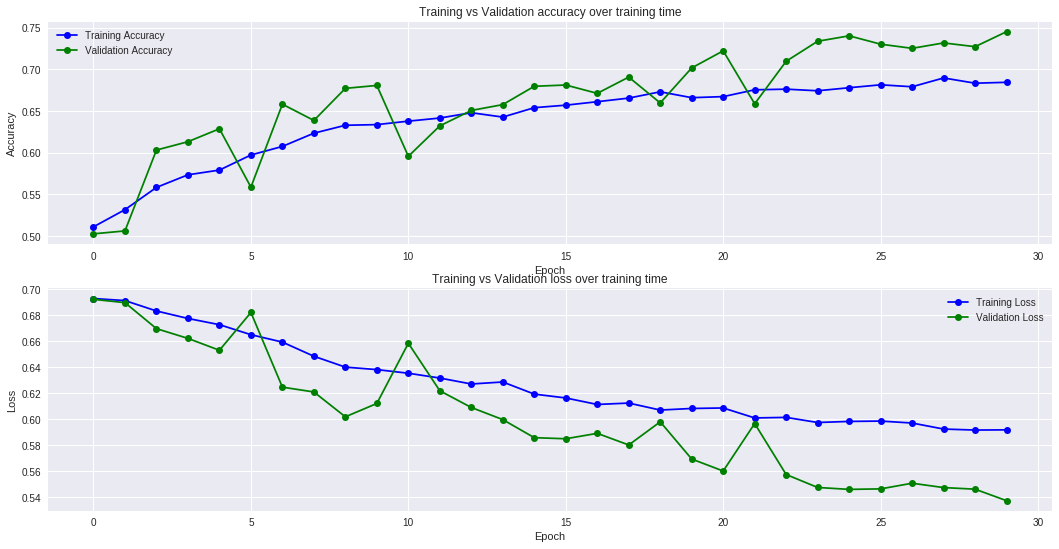

In [0]:
run(5)

In [0]:
run(6)

Already done.


In [0]:
run(7)

Already done.


In [0]:
run(8)

Already done.


In [0]:
run(9)

Already done.
